In [4]:
import cv2
import imutils
import easyocr
from matplotlib import pyplot as plt
import numpy as np
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

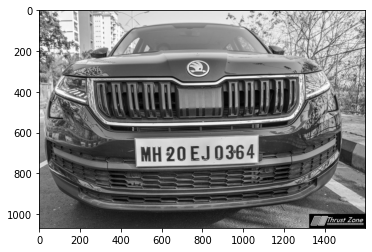

In [5]:
cred = credentials.Certificate("jobista-notifs-firebase-adminsdk-80faj-d0e4323841.json")
firebase_admin.initialize_app(cred)
db = firestore.client()
img = cv2.imread('images/new3.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray,cv2.COLOR_BGR2RGB))

In [6]:
bfilter = cv2.bilateralFilter(gray,11,17,17)
edged = cv2.Canny(bfilter,30,200)
# plt.imshow(cv2.cvtColor(edged,cv2.COLOR_BGR2RGB))

In [7]:
keypoints = cv2.findContours(edged.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours,key = cv2.contourArea,reverse = True)[:10]

In [8]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour,10,True)
    if len(approx) == 4:
        location = approx
        break

In [9]:
location

array([[[1075,  611]],

       [[1072,  749]],

       [[ 474,  765]],

       [[ 468,  626]]], dtype=int32)

In [10]:
mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[location],0,255,-1)
new_image = cv2.bitwise_and(img,img,mask=mask)

In [11]:
# plt.imshow(cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB))

In [12]:
(x,y) = np.where(mask == 255)
(x1,y1) = (np.min(x),np.min(y))
(x2,y2) = (np.max(x),np.max(y))
cropped_image = gray[x1:x2+1,y1:y2+1]

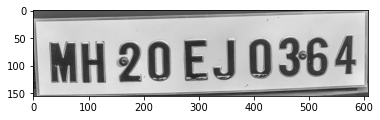

In [13]:
plt.imshow(cv2.cvtColor(cropped_image,cv2.COLOR_BGR2RGB))

In [14]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[23, 31], [603, 31], [603, 144], [23, 144]],
  'MH 20 EJ 0364',
  0.7650929385351155)]

In [134]:
text = result[0][-2]

In [135]:
text

'MH 20 EJ 0364'

In [136]:
if text == 'MH 20 EJ 0364':
    status = db.collection('cars').document('TrwKgUh6ETSnvjGieWhm').get().to_dict()
    status = not status['car_park']
    db.collection('cars').document('TrwKgUh6ETSnvjGieWhm').update({"car_park": status})
else:
    print("Car is not detected");